# The T-Rex Runner AI Trainer

This is AI the training notebook. It's got some details on what happens over time, mini logs and visualizations.

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D, Softmax
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

c:\users\strata\anaconda2\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data = np.load('20180517110204_backup.npz')
images, targets = data['images'], data['targets']

print(images.shape)
print(targets.shape)

(324900, 37, 150)
(324900, 3)


## Data Filtering

I found lots of duplicate frames which are next to each other, possibly due to the high sampling rate of the KL Agent. We need to remove these or else they will make the models overfit and there are plenty of them!

**Historical frames-mode:** We would probably want to keep the repeated frames for the historical prediciton as we will be running the agent in the same sample rate so repeated frames are expected during the actual run.

In [3]:
# def strider(data_length):
#     n = 0
#     while n < (data_length - 1):
#         yield [n, n+1]
#         n += 1

# take_idxs = []
# for a, b in strider(images.shape[0]):
#     if not (images[a] == images[b]).all():
#         take_idxs.append(a)

# print("Data count after de-duplication:", len(take_idxs))
# images_dedup = images[take_idxs]
# targets_dedup = targets[take_idxs]
images_dedup = images[:]
targets_dedup = targets[:]

## Data Balancing

There are lots of idle targets (i.e. where the user does not press any keys) since the objective is to evade obstacles. There are fewer ducks than jumps too. So let's get what ever is smallest and let all other data be the smallest number of targets.

In [4]:
# # Balancing with Random Sampling
# min_target_count = min(targets_dedup.sum(axis=0))
# print(targets_dedup.sum(axis=0))

# # Shuffle the dataset so that we don't get the same data always
# random_indexing = np.random.permutation(np.arange(images_dedup.shape[0]))
# images_shuffled = images_dedup[random_indexing]
# targets_shuffled = targets_dedup[random_indexing]

# images_part, targets_part = None, None

# # Collect the smallest number of target counts
# for target in np.unique(targets_dedup, axis=0):
#     current_target = np.all(np.equal(targets_shuffled, target), axis=1)
#     if images_part is None:
#         images_part = images_shuffled[current_target][:min_target_count]
#         targets_part = targets_shuffled[current_target][:min_target_count]
#     else:
#         images_part = np.vstack([images_part, images_shuffled[current_target][:min_target_count]])
#         targets_part = np.vstack([targets_part, targets_shuffled[current_target][:min_target_count]])

# random_indexing = np.random.permutation(np.arange(targets_part.shape[0]))
# X = images_part[random_indexing].reshape((-1, 37, 150, 1))
# Y = targets_part[random_indexing]
# print(X.shape)
# print(Y.shape)

**New idea:** It seems like the agent often overfits to ducking and never gets back up in many of the models. There might be not enough contextual information between the action frame and the neighboring frames. Perhaps it would be better to target the *jump* and *duck* frames and take a window of ~60 frames on both directions (past and future) as training data. We can then fill the rest of the frames with random *runnning* frames.

In [5]:
# # Balancing with Windowed Sampling
# n_jumps, n_ducks, n_stays = targets_dedup.sum(axis=0)

# # Select window sizes and divisor. This is really trial and error.
# # The divisor determines how much fewer jump target frames to select.
# # Try and get about equal instances of each action.
# window_size_duck = 15
# window_size_jump = 5
# divisor = 2

# is_duck_frames = np.all(np.equal(targets_dedup, np.array([0, 1, 0])), axis=1)
# is_jump_frames = np.all(np.equal(targets_dedup, np.array([1, 0, 0])), axis=1)

# # Get the index of jump and duck frames.
# duck_frames = np.arange(targets_dedup.shape[0])[is_duck_frames]
# jump_frames = np.arange(targets_dedup.shape[0])[is_jump_frames]

# # Take fewer jump frames since we have total duck frames.
# # Also randomize. Change the divisor (//) to optimize with
# # window_size_jump.
# n_take_jump_frames = int(duck_frames.shape[0] * (n_ducks/n_jumps)) // divisor
# jump_frames = np.random.permutation(jump_frames)[:n_take_jump_frames]

# # Add 60 frames to both side for each ducking and jumping frame
# # and np.unique it so we don't have repeated frame indices.
# frame_sets = []
# for frame_idx in duck_frames:
#     frame_sets.append(np.arange(frame_idx - window_size_duck, frame_idx + window_size_duck + 1))

# for frame_idx in jump_frames:
#     frame_sets.append(np.arange(frame_idx - window_size_jump, frame_idx + window_size_jump + 1))

# is_selected_frames = np.zeros(targets_dedup.shape[0], dtype=np.bool)
# for frame_set in frame_sets:
#     is_selected_frames[frame_set] = 1
    
# print(targets_dedup[is_selected_frames].sum(axis=0))
# selected_frame_idxs = np.arange(targets_dedup.shape[0])[is_selected_frames]

# random_indexing = np.random.permutation(selected_frame_idxs)
# X = images_dedup[random_indexing].reshape((-1, 37, 150, 1))
# Y = targets_dedup[random_indexing]
# print(X.shape)
# print(Y.shape)

**Historical frames balancing**

In [6]:
min_action_count = min(targets_dedup.sum(axis=0))
window_size = 4

X = []
Y = []
# Loop over all actions.
for target in np.unique(targets_dedup, axis=0):
    is_action_frames = (targets_dedup == target).all(axis=1)
    action_frame_idxs = np.arange(targets_dedup.shape[0])[is_action_frames]
    # Take a random set of action frames limited by the minimum action count.
    selected_frame_idxs = np.random.permutation(action_frame_idxs)[:min_action_count]

    frame_sets_idxs = []
    # Take a window of historical frames including the current frame (i.e. the action frame).
    for frame_idx in selected_frame_idxs:
        frame_sets_idxs.append(np.arange(frame_idx-window_size, frame_idx+1))

    selected_frame_sets = images_dedup[np.array(frame_sets_idxs)]
    
    # Append the frame sets into X and the labels into Y.
    X.append(selected_frame_sets)
    Y.append(np.repeat(np.expand_dims(target, axis=0), min_action_count, axis=0))

# X and Y are lists, vstacking makes it a numpy ndarray of the right size.
X = np.vstack(X)
Y = np.vstack(Y)

# Shuffle the training sets.
random_indexing = np.random.permutation(np.arange(X.shape[0]))
X = X[random_indexing]
Y = Y[random_indexing]

# Making the training ndarray channels-last, that's how I like it.
X = np.rollaxis(X, 1, 4)

print(X.shape)
print(Y.shape)

(65001, 37, 150, 5)
(65001, 3)


## Create model

Let's create a model using Keras.

**2018-05-15**

We'll do a `CM CM CM CM FD Softmax` network just to see how it perform.

It performed okay, test accuracy of aorund 89%-90%. Trying a smaller version of AlexNet, muAlexNet.

muAlexNet seems to be overfitting, the validation loss increase too much after prolonged-training. Seemingly, stricter models are not working.

**2018-05-16**

Found out that there were many duplicate frames (about 1/3 of the data). This could be the reason for overfitting.

Model still overfits after de-dupe. What could be going on?

Seems like there wasn't enough dropouts between the Conv layers. Added dropout after BatchNorm and now the model is fitting much better. But the fit is around 80% accuracy, which was the max accuracy of the overfitting + de-duped model.

**2018-05-17**

Looks like some of the recently collected data was broken and training inputs don't match frames. This is why we have such low scores. Getting new data.

Model performing better ~90% but overfits later. Trying out some values for the Conv2D filters to make the model smaller.

After several iterations, I'm giving up on the model, the best it could do is ~85% which is fine but not great. Even strided windows don't work well. dino jumps too soon in the early levels and gets stuck in a duck. We need a better method.

** 2018-05-19 **

Trying out a stacked-frames approach. Rather than single-frame predictions, concat 5 historical frames as different image "channels". So we have some velocity-based information when predicting the jumps.

This works well! And the model is much smaller (based on Mnih's paper).

In [7]:
model = Sequential()

model.add(Conv2D(16, (6, 6), strides=(3, 3), padding='same',
                 activation='relu', kernel_regularizer=l2(0.01),
                 input_shape=(37, 150, 5)))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same',
                 activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(16))
model.add(Dense(3))
model.add(Softmax())

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 50, 16)        2896      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 25, 16)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 25, 16)         64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 25, 16)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 13, 32)         4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 3, 13, 32)         128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 13, 32)         0         
__________

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model.compile(Adam(lr=0.0001), 'categorical_crossentropy', metrics=['acc'])

In [9]:
n_epochs = 300
hist = model.fit(X, Y, batch_size=256, epochs=n_epochs, validation_split=0.1, callbacks=[TensorBoard()])

Instructions for updating:
Use the retry module or similar alternatives.
Train on 58500 samples, validate on 6501 samples
Epoch 1/300
58500/58500 [==============================] - 29s 496us/step - loss: 0.8804 - acc: 0.7041 - val_loss: 0.3815 - val_acc: 0.8836
Epoch 2/300
58500/58500 [==============================] - 29s 494us/step - loss: 0.5010 - acc: 0.8442 - val_loss: 0.3438 - val_acc: 0.8977
Epoch 3/300
58500/58500 [==============================] - 29s 494us/step - loss: 0.4342 - acc: 0.8672 - val_loss: 0.3226 - val_acc: 0.9006
Epoch 4/300
58500/58500 [==============================] - 29s 492us/step - loss: 0.3942 - acc: 0.8785 - val_loss: 0.3117 - val_acc: 0.9049
Epoch 5/300
58500/58500 [==============================] - 29s 490us/step - loss: 0.3718 - acc: 0.8845 - val_loss: 0.3011 - val_acc: 0.9085
Epoch 6/300
58500/58500 [==============================] - 29s 493us/step - loss: 0.3551 - acc: 0.8886 - val_loss: 0.2954 - val_acc: 0.9052
Epoch 7/300
58500/58500 [=============

58500/58500 [==============================] - 29s 490us/step - loss: 0.2040 - acc: 0.9241 - val_loss: 0.1802 - val_acc: 0.9326
Epoch 57/300
58500/58500 [==============================] - 28s 477us/step - loss: 0.2021 - acc: 0.9238 - val_loss: 0.1760 - val_acc: 0.9340
Epoch 58/300
58500/58500 [==============================] - 29s 491us/step - loss: 0.2044 - acc: 0.9232 - val_loss: 0.1792 - val_acc: 0.9331
Epoch 59/300
58500/58500 [==============================] - 28s 487us/step - loss: 0.1991 - acc: 0.9252 - val_loss: 0.1777 - val_acc: 0.9334
Epoch 60/300
58500/58500 [==============================] - 28s 487us/step - loss: 0.2012 - acc: 0.9235 - val_loss: 0.1765 - val_acc: 0.9326
Epoch 61/300
58500/58500 [==============================] - 28s 486us/step - loss: 0.2005 - acc: 0.9240 - val_loss: 0.1789 - val_acc: 0.9335
Epoch 62/300
58500/58500 [==============================] - 28s 482us/step - loss: 0.1988 - acc: 0.9238 - val_loss: 0.1792 - val_acc: 0.9334
Epoch 63/300
58500/58500 [

58500/58500 [==============================] - 28s 481us/step - loss: 0.1895 - acc: 0.9285 - val_loss: 0.1710 - val_acc: 0.9365
Epoch 115/300
58500/58500 [==============================] - 28s 487us/step - loss: 0.1886 - acc: 0.9268 - val_loss: 0.1728 - val_acc: 0.9340
Epoch 116/300
58500/58500 [==============================] - 29s 495us/step - loss: 0.1879 - acc: 0.9293 - val_loss: 0.1723 - val_acc: 0.9357
Epoch 117/300
58500/58500 [==============================] - 28s 484us/step - loss: 0.1885 - acc: 0.9289 - val_loss: 0.1725 - val_acc: 0.9360
Epoch 118/300
58500/58500 [==============================] - 28s 482us/step - loss: 0.1881 - acc: 0.9291 - val_loss: 0.1722 - val_acc: 0.9365
Epoch 119/300
58500/58500 [==============================] - 29s 491us/step - loss: 0.1886 - acc: 0.9278 - val_loss: 0.1718 - val_acc: 0.9371
Epoch 120/300
58500/58500 [==============================] - 28s 486us/step - loss: 0.1887 - acc: 0.9289 - val_loss: 0.1724 - val_acc: 0.9352
Epoch 121/300
58500/

Epoch 172/300
58500/58500 [==============================] - 28s 486us/step - loss: 0.1837 - acc: 0.9306 - val_loss: 0.1706 - val_acc: 0.9360
Epoch 173/300
58500/58500 [==============================] - 28s 483us/step - loss: 0.1859 - acc: 0.9291 - val_loss: 0.1708 - val_acc: 0.9359
Epoch 174/300
58500/58500 [==============================] - 28s 486us/step - loss: 0.1830 - acc: 0.9302 - val_loss: 0.1700 - val_acc: 0.9355
Epoch 175/300
58500/58500 [==============================] - 29s 487us/step - loss: 0.1828 - acc: 0.9302 - val_loss: 0.1702 - val_acc: 0.9366
Epoch 176/300
58500/58500 [==============================] - 29s 492us/step - loss: 0.1826 - acc: 0.9302 - val_loss: 0.1703 - val_acc: 0.9368
Epoch 177/300
58500/58500 [==============================] - 28s 483us/step - loss: 0.1844 - acc: 0.9299 - val_loss: 0.1709 - val_acc: 0.9375
Epoch 178/300
58500/58500 [==============================] - 29s 489us/step - loss: 0.1834 - acc: 0.9299 - val_loss: 0.1718 - val_acc: 0.9360
Epoch 

Epoch 230/300
58500/58500 [==============================] - 29s 489us/step - loss: 0.1827 - acc: 0.9310 - val_loss: 0.1709 - val_acc: 0.9363
Epoch 231/300
58500/58500 [==============================] - 29s 488us/step - loss: 0.1816 - acc: 0.9306 - val_loss: 0.1688 - val_acc: 0.9375
Epoch 232/300
58500/58500 [==============================] - 29s 495us/step - loss: 0.1819 - acc: 0.9305 - val_loss: 0.1703 - val_acc: 0.9357
Epoch 233/300
58500/58500 [==============================] - 29s 488us/step - loss: 0.1829 - acc: 0.9301 - val_loss: 0.1699 - val_acc: 0.9362
Epoch 234/300
58500/58500 [==============================] - 29s 487us/step - loss: 0.1817 - acc: 0.9302 - val_loss: 0.1716 - val_acc: 0.9348
Epoch 235/300
58500/58500 [==============================] - 29s 495us/step - loss: 0.1819 - acc: 0.9314 - val_loss: 0.1707 - val_acc: 0.9360
Epoch 236/300
58500/58500 [==============================] - 29s 489us/step - loss: 0.1820 - acc: 0.9298 - val_loss: 0.1708 - val_acc: 0.9345
Epoch 

Epoch 288/300
58500/58500 [==============================] - 29s 492us/step - loss: 0.1813 - acc: 0.9308 - val_loss: 0.1730 - val_acc: 0.9339
Epoch 289/300
58500/58500 [==============================] - 28s 471us/step - loss: 0.1809 - acc: 0.9314 - val_loss: 0.1722 - val_acc: 0.9351
Epoch 290/300
58500/58500 [==============================] - 28s 485us/step - loss: 0.1794 - acc: 0.9306 - val_loss: 0.1707 - val_acc: 0.9351
Epoch 291/300
58500/58500 [==============================] - 29s 492us/step - loss: 0.1802 - acc: 0.9302 - val_loss: 0.1696 - val_acc: 0.9352
Epoch 292/300
58500/58500 [==============================] - 28s 476us/step - loss: 0.1803 - acc: 0.9311 - val_loss: 0.1697 - val_acc: 0.9349
Epoch 293/300
58500/58500 [==============================] - 28s 484us/step - loss: 0.1811 - acc: 0.9312 - val_loss: 0.1702 - val_acc: 0.9355
Epoch 294/300
58500/58500 [==============================] - 29s 488us/step - loss: 0.1802 - acc: 0.9311 - val_loss: 0.1689 - val_acc: 0.9359
Epoch 

## Visualizations

Fooling around the model here, see if there's anything of interest.

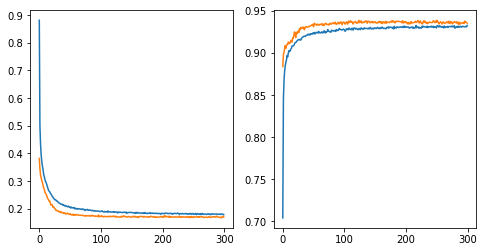

In [10]:
take_n = 300
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot(np.arange(take_n), hist.history['loss'][:take_n])
axs[0].plot(np.arange(take_n), hist.history['val_loss'][:take_n])
axs[1].plot(np.arange(take_n), hist.history['acc'][:take_n])
axs[1].plot(np.arange(take_n), hist.history['val_acc'][:take_n])

### First conv layer filters

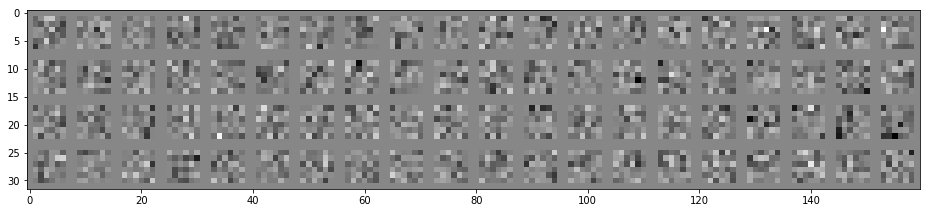

In [11]:
W = model.layers[0].get_weights()[0]

a = []
for h in range(5):
    cols = []
    for i in range(4):
        rows = []
        for j in range(4):
            rows.append(np.pad(W[:, :, h, i*4 + j], ((1, 1), (1, 1)), mode='constant'))
        cols.append(np.hstack(rows))
    a.append(np.vstack(cols))
plt.figure(figsize=(16,9))
plt.imshow(np.hstack(a), cmap='gray')

### Second conv layer filters

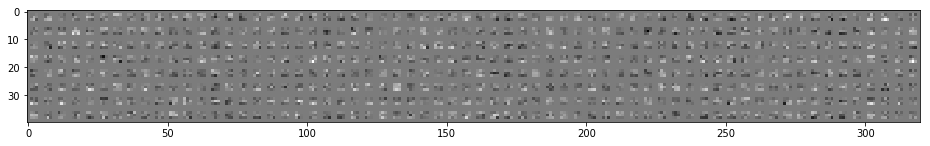

In [12]:
W = model.layers[4].get_weights()[0]

a = []
for h in range(16):
    cols = []
    for i in range(8):
        rows = []
        for j in range(4):
            rows.append(np.pad(W[:, :, h, i*4 + j], ((1, 1), (1, 1)), mode='constant'))
        cols.append(np.hstack(rows))
    a.append(np.vstack(cols))
plt.figure(figsize=(16,9))
plt.imshow(np.hstack(a), cmap='gray')

### Conv outputs

In [13]:
import keras.backend as K

c = K.Function([model.input, K.learning_phase()], [model.layers[0].output])
d = K.Function([model.input, K.learning_phase()], [model.layers[4].output])

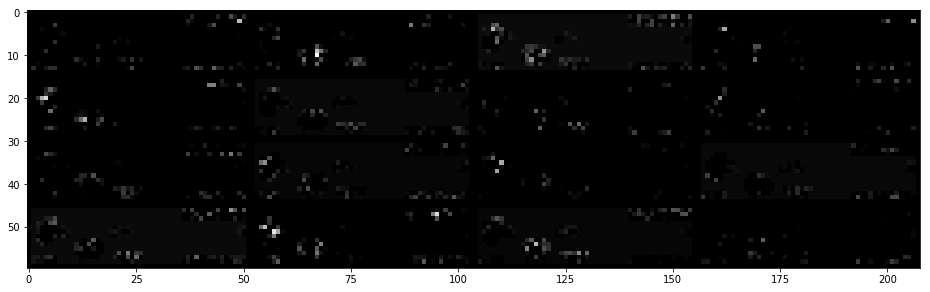

In [14]:
Z = c([X[0:1], 0])[0]

cols = []
for i in range(4):
    rows = []
    for j in range(4):
        rows.append(np.pad(Z[0, :, :, i*4 + j], ((1, 1), (1, 1)), mode='constant'))
    cols.append(np.hstack(rows))
out = np.vstack(cols)
plt.figure(figsize=(16,9))
plt.imshow(out, cmap='gray')

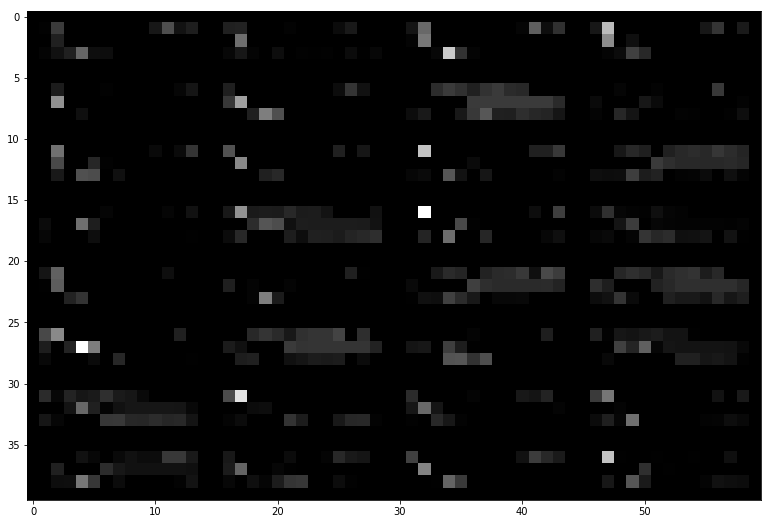

In [15]:
Z = d([X[0:1], 0])[0]

cols = []
for i in range(8):
    rows = []
    for j in range(4):
        rows.append(np.pad(Z[0, :, :, i*4 + j], ((1, 1), (1, 1)), mode='constant'))
    cols.append(np.hstack(rows))
out = np.vstack(cols)
plt.figure(figsize=(16,9))
plt.imshow(out, cmap='gray')

In [16]:
model.save('DinoBotS_v2.h5')